In [184]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sys.path.remove

In [231]:
from pathlib import Path
import sys
PROJECT_ROOT = str(Path('..').resolve())
if not PROJECT_ROOT in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [2]:
import os
from pathlib import Path
import pandas as pd
from pandas import DataFrame
import torch
import torchvision
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import multiprocessing
import munch
from munch import Munch
import affine
from functools import partial
from scipy import ndimage
from torch import Tensor as T
from copy import deepcopy

In [3]:
def N(x):
    if isinstance(x, torch.Tensor):
        if x.is_cuda:
            x = x.cpu()
        return x.numpy()
    else:
        return np.array(x, ndmin=1)

In [4]:
import torchvision.transforms as tfm

In [5]:
from tqdm import tqdm_notebook as tn

## Configuration

In [182]:
CFG = Munch()
CFG.PATH = Path('..').resolve(); 
CFG.DATA = CFG.PATH/'data'
CFG.TRAINVAL = CFG.DATA/'trainval'
CFG.FOLD = CFG.TRAINVAL/'fold1'

# Train and validation splits
CFG.TRN = CFG.TRAINVAL/'trn.csv'
CFG.VAL = CFG.TRAINVAL/'val.csv'

CFG.FORCE_RECOMPUTE_VAL=False  # Recomput the TRN/VAL split (overwrites the csv files)
#CFG.FORCE_RECOMPUTE_VAL=True


CFG.NUM_WORKERS = int(ceil(0.75*multiprocessing.cpu_count()))
CFG.COMPUTE_NORM = False
#CFG.COMPUTE_NORM = True
CFG.NORM_FILE = CFG.TRAINVAL/'norm.npz'

CFG.BATCH_SIZE = 128
CFG.CLASS_WEIGHTS = [1, 1] #50:50

CFG.MAX_EPOCHS = 100
CFG.MAX_OVERFIT = 10

Writing ../lidarboxes/config/default.py


In [7]:
torch.cuda.get_device_name(0)

'Tesla K40c'

In [8]:
torch.cuda.device(0)

## Data 

In [9]:
pos = DataFrame([p.relative_to(CFG.TRAINVAL) for p in CFG.TRAINVAL.glob('pos/*.npz')], 
                columns=['id'])
neg = DataFrame([p.relative_to(CFG.TRAINVAL) for p in CFG.TRAINVAL.glob('neg/*.npz')],
                columns=['id'])
pos['is_box'] = 1
neg['is_box'] = 0

In [10]:
data = pd.concat([pos, neg]).sort_values(by='id').reset_index(drop=True)
data.sample(10)

,id,is_box
1532,neg/001532.npz,0
1910,neg/001910.npz,0
1381,neg/001381.npz,0
1083,neg/001083.npz,0
190,neg/000190.npz,0
226,neg/000226.npz,0
101,neg/000101.npz,0
1529,neg/001529.npz,0
1130,neg/001130.npz,0
145,neg/000145.npz,0


### Splits (TRN / VAL)

In [11]:
if  CFG.FORCE_RECOMPUTE_VAL or not VAL.is_file():
    os.makedirs(CFG.FOLD, exist_ok=True)
    val_mask = np.random.rand(len(data)) < 0.2
    val = data[val_mask].reset_index(drop=True)
    trn = data[~val_mask].reset_index(drop=True)
    val.to_csv(CFG.VAL, index=False)
    trn.to_csv(CFG.TRN, index=False)
else:
    val = pd.read_csv(CFG.VAL)
    trn = pd.read_csv(CFG.TRN)

print(f"{len(trn)} training and {len(val)} validation samples")
print(f"{sum(val['is_box']==1)} positive validation samples")
print(f"{sum(trn['is_box']==1)} positive training samples")

1746 training and 410 validation samples
39 positive validation samples
157 positive training samples


### Dataset (for fast multicore loading / pytorch)

In [12]:
def load_stack(path):
    return np.load(path)['data']

class StackDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.pre_augmented = False
        self.cache_dir = CFG.DATA/'pre-augment-cache'
        self.num_variants = 0
        
    def pre_augment(self, cache_dir=None, num_variants=10, force_recompute=False):
        """Precompute the data augmentation and cache it. 
        
        :param cach_dir: A mirror of the TRAINVAL folder that will hold variations on each input
        :param num_variants: The number of variants of each image to produce
        :param force_recompute: Whether the cach should be replaced (True) or reused if present (False)
        """
        if cache_dir is not None:
            self.cache_dir = cache_dir
        else:
            cache_dir = self.cache_dir
            
        os.makedirs(self.cache_dir, exist_ok=True)
        for i in tqdm(range(len(self)), desc='augmenting', leave=False):
            rec = self.data.iloc[i]
            cache_path = self.cache_dir/Path(rec.id)
            os.makedirs(cache_path, exist_ok=True)
            
            for j in range(num_variants):
                variant_path = cache_path/f"{j}.npz"
                if not variant_path.is_file():
                    x, y = rec.id, rec.is_box
                    x = load_stack(CFG.TRAINVAL/x)
                    if self.transform is not None:
                        x, y = self.transform(x, y) 
                    np.savez(variant_path, x=x, y=y)
        self.pre_augmented = True
        self.num_variants = num_variants
        

        
    def __getitem__(self, index):
        rec = self.data.iloc[index]
        if not self.pre_augmented:
            x, y = rec.id, rec.is_box
            x = load_stack(CFG.TRAINVAL/x)
            if self.transform is not None:
                x, y = self.transform(x, y) 
            return x, y
        else:
            cache_path = self.cache_dir/Path(rec.id)
            j = randint(self.num_variants)
            variant_path = cache_path/f"{j}.npz"
            npz = np.load(variant_path)
            x = npz['x']
            y = npz['y']
            return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
%prun 

### Compute the mean/std for normalization

In [13]:
if  CFG.NORM_FILE.is_file() and not CFG.COMPUTE_NORM:
    npz = np.load(NORM_FILE)
    mu = npz['mu']
    sigma = npz['sigma']
    CFG.COMPUTE_NORM = False
else:
    mu = 0
    sigma = 1
    CFG.COMPUTE_NORM = True

In [14]:
if CFG.COMPUTE_NORM:
    dl = DataLoader(StackDataset(trn), batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS)
    
    x = np.zeros_like(dl.__iter__().next()[0][0])
    xx = zeros_like(x)
    n = 0
    for x_batch, y_batch in tqdm(dl):
        x += x_batch.sum(0)
        xx  += (x_batch**2).sum(0)
        n += len(x_batch)
    mu = x/n
    var = xx/n - mu**2
    eps = sys.float_info.epsilon
    sigma = np.sqrt(var + eps)

    np.savez_compressed(CFG.NORM_FILE, mu=mu, sigma=sigma)

100%|██████████| 14/14 [00:02<00:00,  5.07it/s]


### Create an augmented dataset now that we have $\mu, \sigma$

The stats should not be per-pixel; or rather the objects could occupy any pixel in the image. 

I set the weights for each channel to their mean

In [15]:
mu = mu.reshape(mu.shape[0], -1).mean(1)[:, None, None]
sigma = sigma.reshape(sigma.shape[0], -1).mean(1)[:, None, None]

The torchvision functions do not operate on nd arrays the way I want, so I made my own 'nd' equivalents|

In [16]:
def nd_normalize(x, mu, sigma):
    return (x-mu)/sigma

def nd_denormalize(x, mu, sigma):
    return (x*sigma) + mu

def nd_affine(x, A):
    return ndimage.affine_transform(x, [[1, 0,   0,   0],
                                        [0, A.a, A.b, A.c],
                                        [0, A.d, A.e, A.f]])
def nd_rotation(x, angle=90):
    A = affine.Affine.rotation(angle, pivot=np.array(x.shape[1:])/2.)
    return nd_affine(x, A)

def nd_crop(x, offset, size):
    hi = offset + np.array(size)
    return x[:, offset[0]:hi[0], offset[1]:hi[1]]
     
def nd_center_crop(x, size):
    size = np.array(size)
    offset = (np.array(x.shape[1:]) - size)//2   
    return nd_crop(x, offset, size)

def nd_random_rotation(x, max_angle):
    angle = randint(-max_angle, max_angle)
    return nd_rotation(x, angle)  

def nd_random_crop(x, size):
    size = np.array(size)
    maxoff=np.array(x.shape[1:])-size
    offset = np.array([randint(0, maxoff[0]), 
                       randint(0, maxoff[1])])
    return nd_crop(x, offset, size)

These functions access the global $\mu$ and $\sigma$ 

In [17]:
def normed(x):
    return (x-mu)/sigma

def denormed(x, lidar=True):
    if lidar is False:
        x = x.copy()
        x[:3] = x[:3]*sigma[:3] + mu[:3]
        return x
    else:
        return x*sigma + mu

The data augentation function (using the simpler ones I defined earlier). 

If it is not already clear, these functions transform both the data anf label if needed (like fastai rather than torch)

In [18]:
def transform_stack(x, y):
    x = nd_normalize(x, mu=mu, sigma=sigma)
    x = nd_random_rotation(x, max_angle=90)
    x = nd_center_crop(x, size=3*32)
    x = nd_random_crop(x, size=64) 
    return x, y

In [19]:
trn_ds = StackDataset(trn, transform=transform_stack)
val_ds = StackDataset(val, transform=transform_stack)

In [20]:
trn_ds.pre_augment()

In [21]:
val_ds.pre_augment()

I am  concerned about how long the augmentation takes

In [22]:
%prun x, y = trn_ds[0]

In [23]:
class_sample_count = [sum(trn['is_box']==0), sum(trn['is_box']==1)]
weights = np.array(CFG.CLASS_WEIGHTS) / np.array(class_sample_count)
weights /= weights.sum()
trn_weights = weights[trn['is_box']]
val_weights = weights[val['is_box']]
print(f"class weights are {weights.round(2)}")

class weights are [0.09 0.91]


In [24]:
trn_sampler = torch.utils.data.sampler.WeightedRandomSampler(trn_weights, 2*len(trn_ds))
trn_loader = DataLoader(trn_ds, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, sampler=trn_sampler, pin_memory=True)
#trn_loader = DataLoader(trn_ds, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, pin_memory=True)

val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_weights, 2*len(val_ds))
val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, sampler=val_sampler, pin_memory=True)
#val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE, num_workers=CFG.NUM_WORKERS, pin_memory=True)


### Visualize the data

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [26]:
def plot_rgb(stack):
    plt.imshow(stack[:3].transpose(1,2,0).clip(0,1))    
    plt.xlim(0, stack.shape[1])
    plt.ylim(0, stack.shape[2])
    
def plot_lidar(stack, alpha=1): 
    pseudo = stack[4:7]
    pseudo = pseudo
    pseudo = sigmoid(pseudo.transpose(1,2,0))
    #pseudo -= pseudo.min()
    #pseudo /= pseudo.max()  
    alpha_ = pseudo.max(2)[...,None]*alpha
    pseudo = np.concatenate([pseudo, alpha_], axis=2)          
    plt.imshow(pseudo)
    plt.xlim(0, stack.shape[1])
    plt.ylim(0, stack.shape[2])
    
def set_grid_spacing(minor, major):
    from matplotlib.ticker import MultipleLocator
    ax = gca()
    ax.xaxis.set_minor_locator(MultipleLocator(minor))
    ax.xaxis.set_major_locator(MultipleLocator(major))
    ax.yaxis.set_minor_locator(MultipleLocator(minor))
    ax.yaxis.set_major_locator(MultipleLocator(major))
    ax.grid(which='major')
    ax.grid(which='minor', linestyle='--')
    
def plot3(stack, major=None, minor=None):
    if major is None:
        major = stack.shape[1]//2
    if minor is None:
        minor = major // 4
        
    subplot(131); 
    plot_rgb(stack); 
    set_grid_spacing(minor, major); 
    title('rgb')
    
    subplot(132); 
    plot_rgb(stack); 
    plot_lidar(stack); 
    set_grid_spacing(minor, major);
    
    title('mixed')
    
    subplot(133, facecolor='black'); 
    plot_lidar(stack); 
    set_grid_spacing(minor, major); 
    title('lidar');        

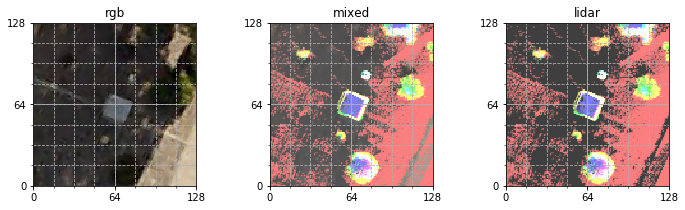

In [27]:
figsize(12, 3)
plot3(load_stack(CFG.TRAINVAL/'pos'/'000000.npz'))

In [156]:
def plot_samples(stacks, lidar_alpha=1, predicted=None, expected=None, denorm=True, rgb=True, lidar=True,  rows=None, fig_kws={}):
    n = len(stacks)
    if rows is None:
        rows = int(ceil(sqrt(n)))
    assert predicted is None or len(predicted) == n
    assert expected is None or len(expected) == n

    fig, axes = plt.subplots(nrows = rows, 
                             ncols=int(ceil(n/rows)), 
                             sharex=True, 
                             sharey=True,
                             subplot_kw=dict(facecolor='black'),
                            **fig_kws)
    
    for i, ax in enumerate(axes.flat):
        sca(ax)
        if i >= len(stacks):
            ax.axis('off')
            continue
        if denorm == 'rgb':
            stack = denormed(stacks[i], lidar=False)
        elif denorm:
            stack = denormed(stacks[i])
        else:
            stack = stacks[i]
        if rgb:
            plot_rgb(stack)
        if lidar:
            plot_lidar(stack, alpha=lidar_alpha)
        if expected is not None:
            text(2, ylim()[1]-2, str(expected[i]), 
                 verticalalignment='top',
                 fontproperties= matplotlib.font_manager.FontProperties(weight='bold'),
                 bbox=dict(facecolor='white', alpha=0.5)
                )
        incorrect = (predicted is not None) and (expected is not None) and (int(predicted[i]) != int(expected[i]))
        if predicted is not None:                
            text(xlim()[1]-2, ylim()[1]-2, str(predicted[i]), color='red' if incorrect else 'blue',
                 verticalalignment='top', horizontalalignment='right',
                 fontproperties= matplotlib.font_manager.FontProperties(weight='bold'),
                 bbox=dict(facecolor='white', alpha=0.5)
                )
        set_grid_spacing(stacks[i].shape[1]//8, stacks[i].shape[1]//2)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    return fig, axes

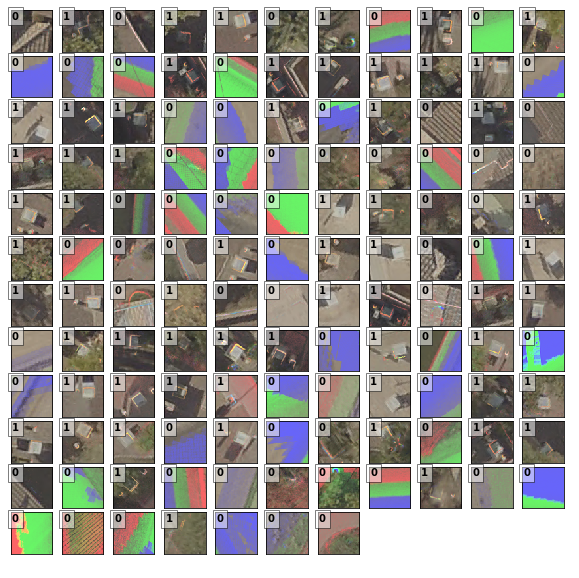

In [29]:
stacks, expected = iter(trn_loader).next()
plot_samples(stacks=N(stacks), denorm='rgb', 
             expected=N(expected), 
             fig_kws=dict(figsize=(10,10)));

# Training

In [30]:
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

To start with, I will use the small vgg13 architecture and refine it. 

In [31]:
vgg = torchvision.models.vgg13_bn(pretrained=True)
rgb_features = deepcopy(vgg.features)
lidar_features = deepcopy(vgg.features)

I need to adjust the number of input channels that the lidar layers expect. The semantics of each channel are different but similar to regular images so I will use the mean of VGG to initialize them.

In [32]:
def change_num_inputs(features, num_in):
    """Changes the number of in_channels for a coinvolution in-place. 
    
    Since the semanics of each input presumably change, this sets them all to their mean
    """
    c0 = features[0]
    c0.in_channels = num_in
    W = c0.weight
    W = W.mean(1)
    W = W[:,None,:,:]
    W = W.expand(-1, num_in, -1, -1)
    W = W.contiguous()
    c0.weight  = nn.Parameter(W)


In [33]:
change_num_inputs(lidar_features, 6)

Make sure that each net can process input of the size we plan to use, and check the number of output features

In [34]:
sz = 64
n_rgb_features = rgb_features.forward(torch.rand((1, 3,  sz, sz))).view(1, -1).shape[1]
n_rgb_features

2048

In [35]:
rgb_features.forward(torch.rand((1, 3,  sz, sz))).shape

torch.Size([1, 512, 2, 2])

In [36]:
sz = 64
n_lidar_features = lidar_features.forward(torch.rand((1, 6,  sz, sz))).view(1, -1).shape[1]
n_lidar_features

2048

In [37]:
def set_trainable(module, b=True):
    module.trainable = b
    for p in module.parameters(): 
        p.requires_grad=b
    
    for c in module.children():
        set_trainable(c, b)

def set_frozen(m, b=True):
    set_trainable(m, not b)

In [38]:
class LidarDataFusionClassifier(nn.Module):
    def __init__(self,
                 rgb_features,
                 lidar_features, 
                 sz=64,
                 nhidden=[512, 512], 
                 n_out=2):
        super().__init__()
        
        # Use late fusion -- each source of data gets its own feature map
        self.rgb_features = rgb_features
        self.lidar_features = lidar_features
        
        # Compute the number of RGB and lidar features
        n_rgb_features = self.rgb_features.forward(torch.rand((1, 3,  sz, sz))).shape
        n_lidar_features = self.lidar_features.forward(torch.rand((1, 6,  sz, sz))).shape
        
        # Make it fully convolutional so there is 1 outpur for each sz x sz input
        self.bottleneck = nn.MaxPool2d(n_rgb_features[2])
        
        # Concatenate the feature maps
        n_in = n_rgb_features[1] + n_lidar_features[1]
        
        # Do the final classification (using convolutions)
        cl = []
        for h in nhidden:
            fc = [nn.Conv2d(n_in, h, kernel_size=1), nn.ReLU(inplace=True), nn.Dropout(p=0.5)]
            n_in = h
            cl += fc
        cl.append(nn.Conv2d(n_in, n_out, kernel_size=1))
        cl.append(nn.LogSoftmax(dim=1))
        self.classifier = nn.Sequential(*cl)
        
    def forward(self, x):
        bs = x.shape[0]
        
        # Split out the different typoes of input
        rgb_in = x[:,:3]
        lidar_in = x[:,3:]
        
        # Process each type of data with it own feature map
        rgb_features = self.rgb_features.forward(rgb_in)
        lidar_features = self.lidar_features.forward(lidar_in)
        
        # Make sure there is one output for a sz x sz input
        lidar_features = self.bottleneck(lidar_features)
        rgb_features = self.bottleneck(rgb_features)
        
        # Concatenate the different sources
        concat= torch.cat([rgb_features, lidar_features], dim=1)
               
        # Do the final classification
        scores = self.classifier.forward(concat)
        return scores

In [39]:
net = LidarDataFusionClassifier(rgb_features, lidar_features)

In [40]:
net.cuda();

In [41]:
set_trainable(net)
set_frozen(net.rgb_features)
set_frozen(net.lidar_features)

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion.cuda()

optimizer = optim.Adam([ p for p in net.parameters() if p.requires_grad],
                       lr=0.001, weight_decay=0.001)

In [43]:
class EpochData(Munch):
    def __init__(self, epoch, trn_loss, val_loss, CM):
        super().__init__()
        eps = sys.float_info.epsilon
        self.epoch = epoch
        self.trn_loss = trn_loss
        self.val_loss = val_loss
        self.CM = CM
        self.TN, self.FN, self.FP, self.TP = CM.flat
        self.Acc = (self.TP + self.TN)/(sum(CM.flat))
        self.P = self.TP/(self.TP + self.FP + eps)
        self.R = self.TP/(self.TP + self.FN + eps)
        self.beta = 2
        self.F = (1 + self.beta**2)*self.P*self.R/(self.beta**2 * self.P + self.R + eps)
         
    def __repr__(self):
        return (f"epoch {self.epoch: 5} "+
                f"trn_loss={self.trn_loss: 5.2} " +
                f"val_loss={self.val_loss: 5.2} " +
                f"F_{self.beta}={self.F: 5.1%}  " +
                f"Acc={self.Acc: 5.1%}  "+
                f"P={self.P: 5.1%}  "+
                f"R={self.R: 5.1%}")

I stole this progressbar code from fastai -- it avoids some glitches of using tqdm inside jupyter notebooks

In [72]:
import tqdm as tq
def clear_tqdm():
    inst = getattr(tq.tqdm, '_instances', None)
    if not inst: return
    try:
        for i in range(len(inst)): inst.pop().close()
    except Exception:
        pass

def tqdm(*args, **kwargs):
    clear_tqdm()
    return tq.tqdm(*args, file=sys.stdout, **kwargs)

def trange(*args, **kwargs):
    clear_tqdm()
    return tq.trange(*args, file=sys.stdout, **kwargs)


In [76]:
import shutil


class Solver(object):
    def __init__(self, trn_loader, val_loader, net, optimizer, criterion):
        super().__init__()
        self.trn_loader = trn_loader
        self.val_loader = val_loader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = []
        self.best_epoch = -1 
        self.best_val_loss = sys.float_info.max
        self.epoch = 0
        
    def save_checkpoint(self, state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
            
    def restore_checkpoint(filename):
        checkpoint = torch.load(filename)
        self.epoch = checkpoint['epoch']
        self.best_epoch = checkpoint['best_epoch']
        self.best_val_loss = checkpoint['best_val_loss']
        self.net.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.history = checkpoint['history']

    def train(self):
 
        # Compute initial validation
        val_loss = 0
        CM = np.zeros((2,2))
        net.eval()
        val_pb = tqdm(self.val_loader, "computing validation", leave=False)
        for x, y in val_pb:
            x, y = x.cuda(), y.cuda()
            p = net.forward(x).squeeze()
            c = torch.argmax(p, dim=1).squeeze()
            CM += np.bincount(2*y+c, minlength=4).reshape(2,2)
            loss = criterion(p, y)
            val_loss += loss.item()
            val_pb.set_description(f"val_loss={val_loss:5.2}")
        val_pb.close()
        self.history.append(EpochData(epoch=self.epoch, trn_loss=float('nan'), val_loss=val_loss, CM=CM))
        print(self.history[-1])
  
        for epoch_ in trange(CFG.MAX_EPOCHS):  # loop over the dataset multiple times           
            # Training for one epoch
            net.train()
            trn_loss = 0.0
            trn_pb = tqdm(self.trn_loader, 'batches', leave=False)
            for (x, y) in trn_pb:
                # put input ionto the GPU
                x, y = x.cuda(), y.cuda()
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                p = net(x)
                loss = criterion(p.squeeze(), y)
                loss.backward()
                optimizer.step()

                # print statistics
                trn_loss += loss.item()
                trn_pb.set_description(f"trn_loss={trn_loss:5.2}")
            trn_pb.close()

            # Compute validation
            val_loss = 0
            CM = np.zeros((2,2))
            net.eval()
            val_pb = tqdm(self.val_loader, "computing validation", leave=False)
            for x, y in val_pb:
                x, y = x.cuda(), y.cuda()
                p = net.forward(x).squeeze()
                c = torch.argmax(p, dim=1).squeeze()
                CM += np.bincount(2*y+c, minlength=4).reshape(2,2)
                loss = criterion(p, y)
                val_loss += loss.item()
                val_pb.set_description(f"val_loss={val_loss:5.2}")
            val_pb.close()
            
            self.epoch += 1
            self.history.append(EpochData(epoch=self.epoch, trn_loss=trn_loss, val_loss=val_loss, CM=CM))
            
            print(self.history[-1])
            
            if val_loss < self.best_val_loss:
                self.best_epoch = self.epoch
                self.best_val_loss = val_loss

            self.save_checkpoint({
                    'epoch': self.epoch,
                    'history': self.history,
                    'state_dict': net.state_dict(),
                    'best_epoch': self.best_epoch,
                    'best_val_loss': self.best_val_loss,
                    'optimizer' : self.optimizer.state_dict(),
                }, is_best=(self.epoch == self.best_epoch) )

            if (self.epoch - self.best_epoch) > CFG.MAX_OVERFIT:
                print(f"No improvement within {self.epoch - self.best_epoch} epochs, you are done!")
                break

        print('Finished Training')

In [77]:
solver = Solver(trn_loader=trn_loader, val_loader=val_loader, 
                net=net, optimizer=optimizer, criterion=criterion)

In [78]:
print(f"CFG.MAX_EPOCHS={CFG.MAX_EPOCHS}")
print(f"CFG.NUM_WORKERS={CFG.NUM_WORKERS}")
solver.train()

CFG.MAX_EPOCHS=100
CFG.NUM_WORKERS=30
epoch     0 trn_loss=  nan val_loss=  1.2 F_2= 96.6%  Acc= 94.5%  P= 91.8%  R= 97.8%
epoch     1 trn_loss=  2.8 val_loss= 0.84 F_2= 95.5%  Acc= 96.2%  P= 97.2%  R= 95.1%
epoch     2 trn_loss=  2.3 val_loss= 0.69 F_2= 97.3%  Acc= 96.3%  P= 95.1%  R= 97.9%
epoch     3 trn_loss=  2.1 val_loss= 0.75 F_2= 94.9%  Acc= 95.6%  P= 97.4%  R= 94.3%
epoch     4 trn_loss=  1.8 val_loss= 0.71 F_2= 98.0%  Acc= 96.5%  P= 94.1%  R= 99.0%
epoch     5 trn_loss=  2.1 val_loss= 0.91 F_2= 97.3%  Acc= 94.5%  P= 90.1%  R= 99.2%
epoch     6 trn_loss=  1.7 val_loss= 0.95 F_2= 95.8%  Acc= 94.5%  P= 91.8%  R= 96.9%
epoch     7 trn_loss=  1.7 val_loss= 0.92 F_2= 97.8%  Acc= 96.0%  P= 93.4%  R= 99.0%
epoch     8 trn_loss=  2.3 val_loss=  1.6 F_2= 96.8%  Acc= 94.6%  P= 90.9%  R= 98.4%
epoch     9 trn_loss=  2.9 val_loss= 0.93 F_2= 96.0%  Acc= 96.1%  P= 96.3%  R= 95.9%
epoch    10 trn_loss=  2.6 val_loss= 0.81 F_2= 96.3%  Acc= 95.9%  P= 94.7%  R= 96.7%
epoch    11 trn_loss=  1.4 

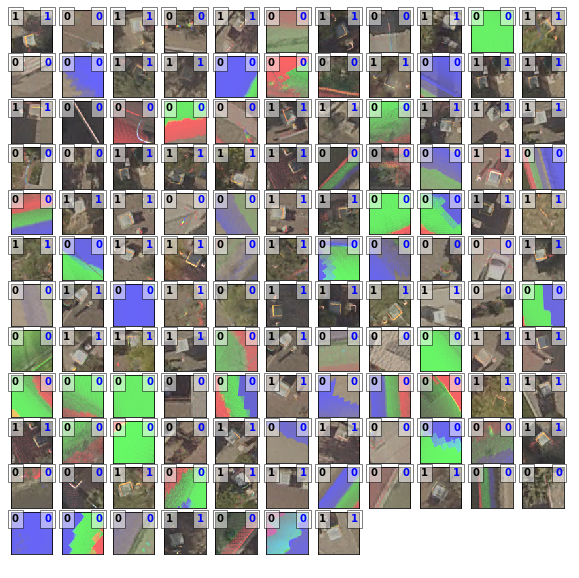

In [87]:
stacks, expected = iter(trn_loader).next()
net.eval()
predicted = net(stacks.cuda()).squeeze().argmax(1)

plot_samples(stacks=N(stacks.cpu()), denorm='rgb', 
             expected=N(expected.cpu()), predicted=N(predicted.cpu()),
             fig_kws=dict(figsize=(10,10)));

### Hard Sampling for negatives

In [117]:
hardness = np.zeros(len(trn_ds))

net.eval()
dl = DataLoader(trn_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
pb = trange(len(dl))
dli = iter(dl)
for bi in pb:
    i = bi*dl.batch_size
    x, y = dli.next()
    p = net(x.cuda()).squeeze().cpu().detach()
    x.cpu()
    p = N(p)
    y = N(y)
    batch_hardness = exp(p[:,1]*(1-y) + p[:, 0]*y).round(2)
    hardness[i:i+len(batch_hardness)] = batch_hardness
pb.close()

100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Process Process-3271:
Process Process-3284:
Process Process-3286:
Process Process-3279:
Process Process-3272:
Process Process-3289:
Process Process-3291:
Process Process-3273:
Traceback (most recent call last):
Process Process-3297:
Process Process-3294:
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-3285:
Process Process-3298:
Process Process-3296:
Traceback (most recent call last):
Traceback (most 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/pyth

  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages

  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 

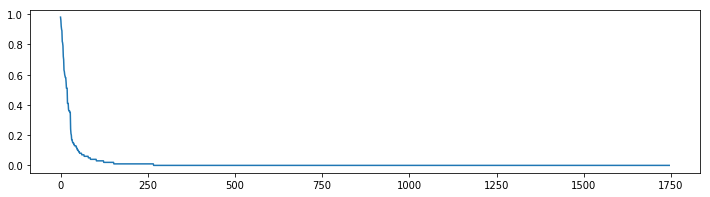

In [127]:
plot(hardness[argsort(hardness)][::-1])

In [130]:
trn_loader.sampler.weights += T(hardness).to(torch.double)

In [136]:
!cp model_best.pth.tar model_best-easy.pth.tar
CFG.MAX_OVERFIT = 1e6
solver.optimizer= optim.Adam([ p for p in net.parameters() if p.requires_grad],
                       lr=0.0001, 
                       weight_decay=0.001)
solver.train()

epoch    43 trn_loss=  nan val_loss= 0.45 F_2= 97.9%  Acc= 98.0%  P= 98.3%  R= 97.8%
epoch    44 trn_loss=  1.5 val_loss= 0.73 F_2= 96.6%  Acc= 96.7%  P= 96.8%  R= 96.6%
epoch    45 trn_loss=  1.8 val_loss= 0.67 F_2= 98.2%  Acc= 97.3%  P= 96.0%  R= 98.8%
epoch    46 trn_loss=  1.6 val_loss=  1.7 F_2= 97.1%  Acc= 93.9%  P= 88.8%  R= 99.5%
epoch    47 trn_loss=  1.4 val_loss=  1.2 F_2= 97.5%  Acc= 94.5%  P= 89.6%  R= 99.7%
epoch    48 trn_loss=  1.4 val_loss= 0.64 F_2= 96.7%  Acc= 95.9%  P= 95.0%  R= 97.2%
epoch    49 trn_loss=  1.2 val_loss= 0.88 F_2= 98.3%  Acc= 96.8%  P= 94.7%  R= 99.3%
epoch    50 trn_loss=  1.0 val_loss=  1.3 F_2= 97.6%  Acc= 95.5%  P= 91.6%  R= 99.2%
epoch    51 trn_loss=  2.1 val_loss=  1.1 F_2= 97.5%  Acc= 96.6%  P= 95.4%  R= 98.1%
epoch    52 trn_loss=  1.0 val_loss= 0.53 F_2= 97.9%  Acc= 97.0%  P= 95.9%  R= 98.4%
epoch    53 trn_loss=  1.6 val_loss=  0.7 F_2= 97.8%  Acc= 96.6%  P= 94.4%  R= 98.7%
epoch    54 trn_loss=  1.4 val_loss=  2.1 F_2= 96.0%  Acc= 90.5% 

Process Process-6114:
Process Process-6120:
Process Process-6119:
Process Process-6118:
Process Process-6107:
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
Process Process-6108:
Process Process-6109:


KeyboardInterrupt: 

Process Process-6104:
Process Process-6098:
Process Process-6110:
Process Process-6111:
Process Process-6113:
Process Process-6117:
Process Process-6091:
Process Process-6099:
Process Process-6100:
Process Process-6092:
Process Process-6094:
Process Process-6096:
Process Process-6103:
Process Process-6101:
Process Process-6105:
Process Process-6115:
Process Process-6095:
Process Process-6116:
Process Process-6097:
Process Process-6093:
Process Process-6112:
Traceback (most recent call last):
Process Process-6106:
Process Process-6102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", lin

  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r

  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/site-packages/torch/utils/data/dataloader.py

  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/femianjc/anaconda2/envs/srp3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf =

In [153]:
def get_hardness(net, ds, batch_size=CFG.BATCH_SIZE, num_workers =CFG.NUM_WORKERS):
    hardness = np.zeros(len(trn_ds))

    net.eval()
    dl = DataLoader(ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    pb = trange(len(dl))
    dli = iter(dl)
    for bi in pb:
        i = bi*dl.batch_size
        x, y = dli.next()
        p = net(x.cuda()).squeeze().cpu().detach()
        x.cpu()
        p = N(p)
        y = N(y)
        batch_hardness = exp(p[:,1]*(1-y) + p[:, 0]*y).round(2)
        hardness[i:i+len(batch_hardness)] = batch_hardness
    pb.close()
    
    return hardness

In [154]:
def plot_hardest(net, ds, hardness, num=16, figsize=(8,8)):
    hardest = argsort(hardness)[::-1][:num]
    x, y = zip(*[ds[i] for i in hardest])
    predicted = net.eval()(T(x).cuda()).squeeze().argmax(1).cpu().numpy()
    plot_samples(x, expected=y, predicted=predicted, fig_kws=dict(figsize=figsize));

100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


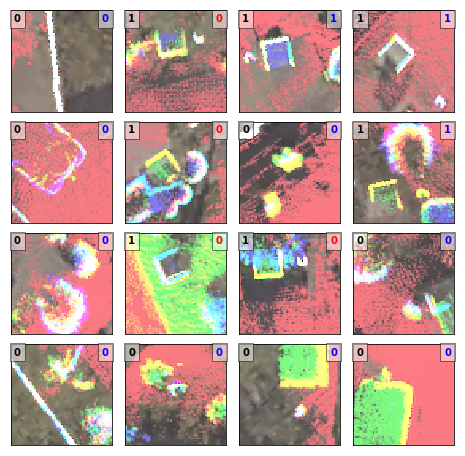

In [158]:
plot_hardest(net, val_ds, get_hardness(net, val_ds))